<a href="https://colab.research.google.com/github/pk2971/computational-gender-analysis/blob/main/notebooks/Token_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import zipfile
import xml.etree.ElementTree as ET
import re
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


In [9]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
zip_path = '/content/drive/MyDrive/debates.zip'
# Clean and parse XML text
def extract_text_from_speech(xml_bytes):
    try:
        root = ET.fromstring(xml_bytes)
        return ' '.join([p.text or '' for p in root.findall('.//speech//p')])
    except ET.ParseError:
        return ""

In [11]:
def get_year_from_filename(filename):
    match = re.search(r'debates(\d{4})', filename)
    return int(match.group(1)) if match else None


In [12]:
def collect_documents_by_year(zip_path, start_year, end_year):
    year_docs = defaultdict(str)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if not file_name.endswith('.xml'):
                continue
            year = get_year_from_filename(file_name)
            if year and start_year <= year <= end_year:
                with zip_ref.open(file_name) as f:
                    xml_bytes = f.read()
                    year_docs[year] += extract_text_from_speech(xml_bytes) + " "
    return year_docs

In [25]:
extended_stopwords = [
    # Standard English stopwords (already in NLTK/Scikit-learn)
    # Custom additions:
    "shall", "may", "also", "must", "however", "therefore", "thus", "hereby", "whereas", "therein",
    "thereof", "herein", "therewith", "thereupon", "hereafter", "herewith", "hereupon", "hereinbefore",
    "hereinafter", "hence", "furthermore", "further", "meanwhile", "nevertheless", "nonetheless",
    "notwithstanding", "wherein", "whereby", "whereupon", "whereof", "whilst", "amongst", "upon",
    "whereas", "aforementioned", "said", "such", "one", "two", "three", "four", "five", "six", "seven",
    "eight", "nine", "ten", "first", "second", "third", "forth", "fifth", "sixth", "seventh", "eighth",
    "ninth", "tenth", "mr", "mrs", "ms", "hon", "honourable", "gentleman", "gentlemen", "lady", "lord",
    "member", "members", "committee", "house", "assembly", "parliament", "bill", "act", "motion",
    "debate", "question", "answer", "clause", "subsection", "section", "amendment", "order", "session",
    "speaker", "government", "minister", "secretary", "right", "left", "mr.", "mrs.", "ms.", "hon.",
    "honourable.", "gentleman.", "gentlemen.", "lady.", "lord.", "member.", "members.", "committee.",
    "house.", "assembly.", "parliament.", "bill.", "act.", "motion.", "debate.", "question.", "answer.",
    "clause.", "subsection.", "section.", "amendment.", "order.", "session.", "speaker.", "government",
    "minister.", "secretary",
    # Modal verbs, formalities, and filler words
    "would", "could", "should", "might", "can", "will", "do", "does", "did", "done", "being", "having",
    "make", "made", "take", "taken", "give", "given", "get", "got", "go", "going", "say", "said", "come",
    "came", "see", "seen", "think", "thought", "know", "known", "let", "lets", "much", "many", "few",
    "several", "any", "every", "each", "other", "others", "another", "more", "most", "some", "anyone",
    "anything", "everyone", "everything", "none", "nothing", "always", "never", "sometimes", "often",
    "already", "yet", "still", "just", "even", "ever", "back", "forward", "again", "new", "old",
    "whether","put","cannot","like","though","asked",

    # Numbers as words
    "zero", "hundred", "thousand", "million", "billion", "trillion"]


In [ ]:
def get_top_tfidf_words(zip_path, year_input, top_n=20, extra_stopwords=[]):
    # Parse year range
    if isinstance(year_input, int):
        start_year, end_year = year_input, year_input
    else:
        start_year, end_year = year_input

    # Collect documents by year
    year_docs = collect_documents_by_year(zip_path, start_year, end_year)
    years = sorted(year_docs.keys())
    documents = [year_docs[year] for year in years]

    # Prepare stopwords
    stop_words = list(set(stopwords.words('english')).union(set(extra_stopwords)).union(set(extended_stopwords)))

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    # Get top words for each year
    for idx, year in enumerate(years):
        tfidf_scores = tfidf_matrix[idx].toarray().flatten()
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_words = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
        print(f"\nTop words for {year}:")
        for word, score in top_words:
            print(f"{word}: {score:.4f}")

In [22]:
get_top_tfidf_words('/content/drive/MyDrive/debates.zip', 1919, top_n=50, extra_stopwords=["000"])



Top words for 1919:
war: 0.2260
country: 0.2133
time: 0.1820
friend: 0.1750
men: 0.1748
great: 0.1655
us: 0.1231
present: 0.1222
matter: 0.1198
people: 0.1187
state: 0.1150
board: 0.1089
case: 0.1040
trade: 0.1028
regard: 0.0990
work: 0.0977
part: 0.0959
point: 0.0954
way: 0.0949
day: 0.0930
view: 0.0896
whole: 0.0866
years: 0.0846
hope: 0.0842
quite: 0.0827
far: 0.0799
local: 0.0798
possible: 0.0791
man: 0.0781
service: 0.0781
want: 0.0780
position: 0.0778
land: 0.0778
general: 0.0768
last: 0.0761
public: 0.0745
number: 0.0745
year: 0.0739
fact: 0.0724
british: 0.0712
certain: 0.0710
per: 0.0688
deal: 0.0677
labour: 0.0661
gallant: 0.0648
army: 0.0634
pay: 0.0633
aware: 0.0628
without: 0.0626
money: 0.0622


In [30]:
def plot_word_importance(zip_path, word, year_input, extra_stopwords=[]):
    # Parse year range
    if isinstance(year_input, int):
        start_year, end_year = year_input, year_input
    else:
        start_year, end_year = year_input

    # Collect documents by year
    year_docs = collect_documents_by_year(zip_path, start_year, end_year)
    years = sorted(year_docs.keys())
    documents = [year_docs[year] for year in years]

    # Prepare stopwords
    stop_words = list(set(stopwords.words('english')).union(set(extra_stopwords).union(set(extended_stopwords))))

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    # Get importance of the word for each year
    word = word.lower()
    if word not in feature_names:
        print(f"'{word}' not found in the vocabulary.")
        return

    word_idx = list(feature_names).index(word)
    importances = tfidf_matrix[:, word_idx].toarray().flatten()

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(years, importances, marker='o', linestyle='-', color='b')
    plt.title(f"TF-IDF Importance of '{word}' from {years[0]} to {years[-1]}")
    plt.xlabel("Year")
    plt.ylabel("TF-IDF Importance")
    plt.grid(True)
    plt.xticks(years)
    plt.show()


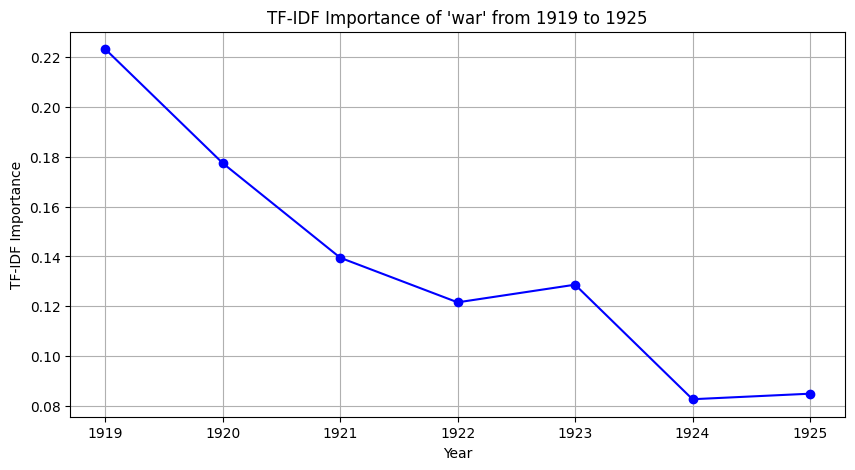

In [31]:
plot_word_importance('/content/drive/MyDrive/debates.zip', 'war', (1919, 1925), extra_stopwords=["shall", "may", "also"])
